# Imports

In [65]:
import os
import string
import time
import unicodedata

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import torch
from torch.utils.data import TensorDataset, SubsetRandomSampler, DataLoader
from torch import nn
import torch.nn.functional as F
from torch import optim
import seaborn as sns
from warnings import filterwarnings

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
filterwarnings('ignore')
sns.set()

In [67]:
%reload_ext autoreload
%autoreload 2

In [68]:
torch.__version__

'1.0.0'

# Introduction 

In this notebook, we will be training a RNN using dataset of names from 18 different languages. When training is done, our RNN should be able to classify the name into one of the 18 different languages. Below are the languages:

In [69]:
PATH = Path('../data/names/')
languages = sorted([fname.stem for fname in PATH.glob('*.txt')])
languages

['Arabic',
 'Chinese',
 'Czech',
 'Dutch',
 'English',
 'French',
 'German',
 'Greek',
 'Irish',
 'Italian',
 'Japanese',
 'Korean',
 'Polish',
 'Portuguese',
 'Russian',
 'Scottish',
 'Spanish',
 'Vietnamese']

# Load Data

In [71]:
!ls {PATH}

Arabic.txt     English.txt    Irish.txt      Polish.txt     Spanish.txt
Chinese.txt    French.txt     Italian.txt    Portuguese.txt Vietnamese.txt
Czech.txt      German.txt     Japanese.txt   Russian.txt
Dutch.txt      Greek.txt      Korean.txt     Scottish.txt


In [72]:
%%bash
cd ../data/names/
wc -l *.txt| sort -r

   20074 total
    9408 Russian.txt
    3668 English.txt
    2000 Arabic.txt
     991 Japanese.txt
     724 German.txt
     709 Italian.txt
     519 Czech.txt
     298 Spanish.txt
     297 Dutch.txt
     277 French.txt
     268 Chinese.txt
     232 Irish.txt
     203 Greek.txt
     139 Polish.txt
     100 Scottish.txt
      94 Korean.txt
      74 Portuguese.txt
      73 Vietnamese.txt


Overall, we have 20,074 names Where Russian names are the majority with 9,408 and Portuguese and Vietnamese have the least names.

In [73]:
# View first 5 names from the Arabic language
!head -5 {PATH  / 'Arabic.txt'}

Khoury
Nahas
Daher
Gerges
Nazari


In [74]:
def unicode_to_ascii(s, vocab):
    '''Convert a unicode string to ascii.'''
    res = []

    for c in unicodedata.normalize('NFD', s):
        if unicodedata.category(c) != 'Mn' and c in vocab:
            res.append(c)
    
    return ''.join(res)

In [75]:
vocab = string.ascii_lowercase
# Read the data
raw_names = []
raw_languages = []
for fname in PATH.glob('*.txt'):
    with open(fname, 'r', encoding='utf-8') as f:
        tmp = f.read().strip().lower().split('\n')
        tmp = [unicode_to_ascii(name, vocab) for name in tmp]
        raw_names.append(tmp)
        raw_languages.append([fname.stem] * len(tmp))

In [76]:
raw_names[0][:5], raw_languages[0][:5]

(['abl', 'adsit', 'ajdrna', 'alt', 'antonowitsch'],
 ['Czech', 'Czech', 'Czech', 'Czech', 'Czech'])

# Data Exploration

In [77]:
# Flatten languages (labels) and check if it equals the previous numbers
languages = [lang for language in raw_languages for lang in language]
pd.Series(languages).value_counts()

Russian       9408
English       3668
Arabic        2000
Japanese       991
German         724
Italian        709
Czech          519
Spanish        298
Dutch          297
French         277
Chinese        268
Irish          232
Greek          203
Polish         139
Scottish       100
Korean          94
Portuguese      74
Vietnamese      73
dtype: int64

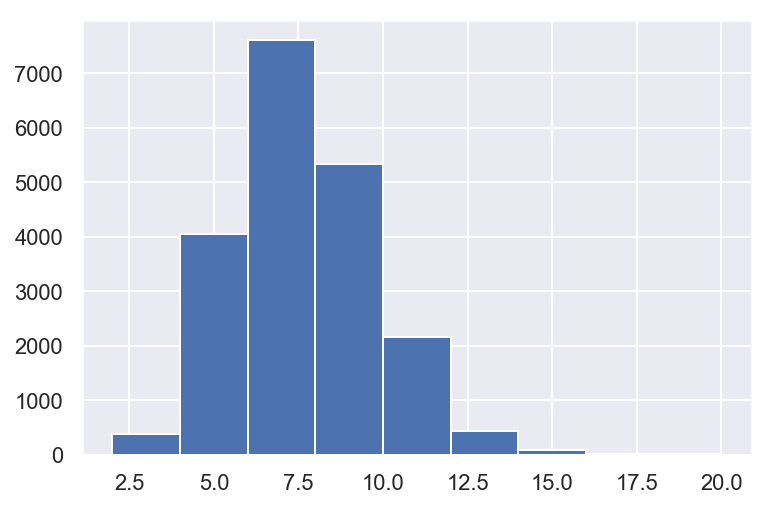

In [78]:
# Distribution of length of all names
names_lengths = [len(name) for language in raw_names for name in language]
plt.hist(names_lengths, bins=np.arange(2, 21, 2));

In [79]:
max(names_lengths)

19

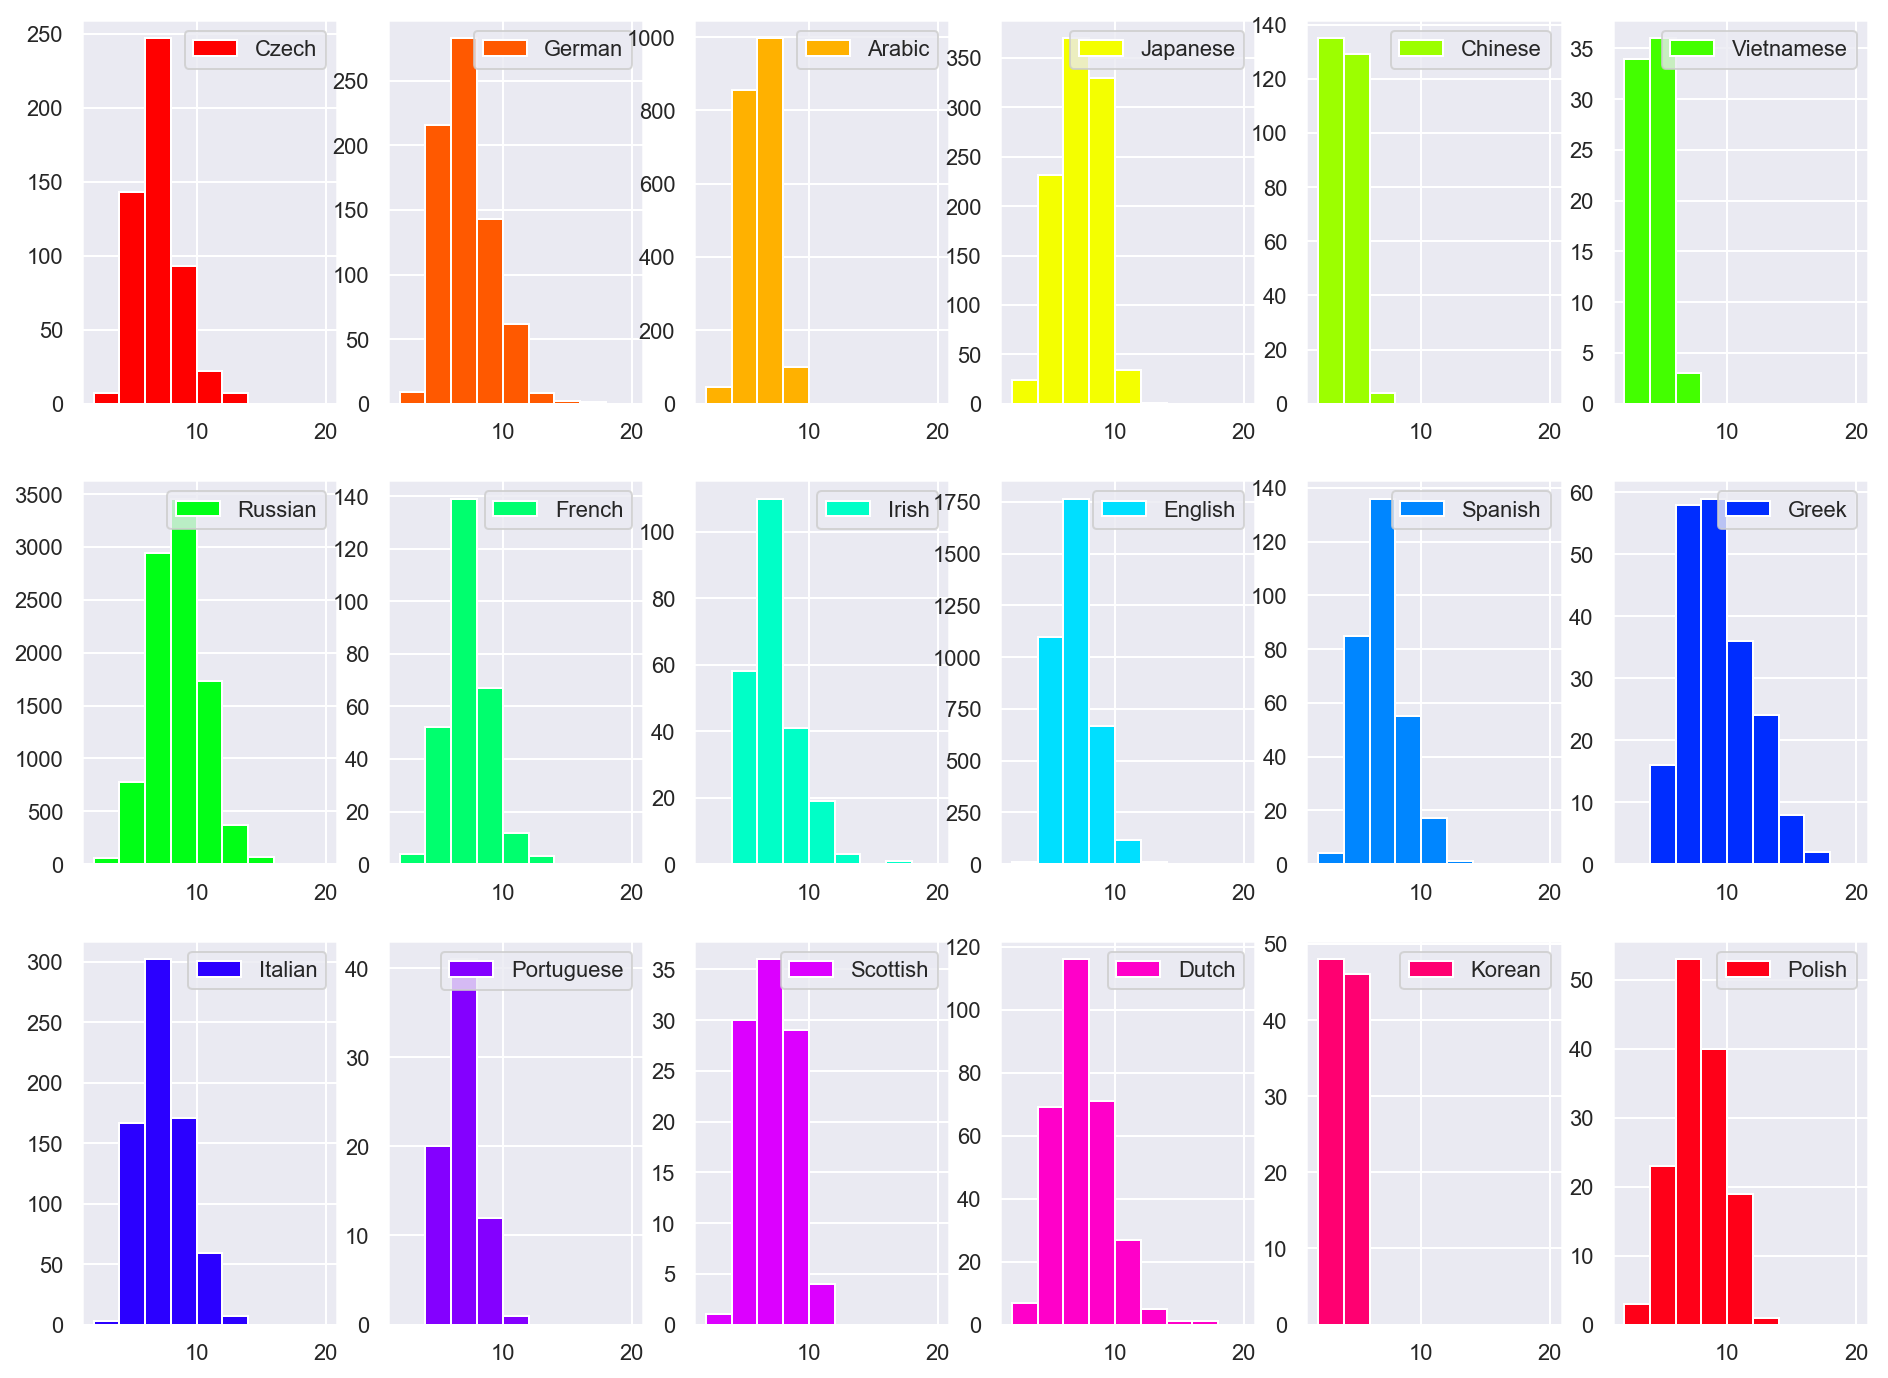

In [80]:
# Distribution of of length of names by language
def get_cmap(n, name='hsv'):
    return plt.cm.get_cmap(name, n)

cmap = get_cmap(len(raw_languages))
fig = plt.figure(figsize=(16, 12))
for i, language in enumerate(raw_languages):
    tmp = [len(name) for name in raw_names[i]]
    fig.add_subplot(3, 6, i + 1)
    plt.hist(tmp, bins=range(2, 21, 2), color=cmap(i), label=language)
    plt.legend()

# Preprocessing 

We won't do any preprocessing here other than converting all names to lower case.

In [202]:
# Create a vocab
names = [name for names in raw_names for name in names]
vocab = sorted(list(set(''.join(names))))
char_to_idx = {char:(ord(char) - 96) for char in vocab}
idx_to_char = {idx:char for char, idx in char_to_idx.items()}
vocab[:10]

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']

In [203]:
# Create dictionary for lang2labels and labels2lang
lang_to_labels = {language:label for label, language in enumerate(sorted(list(set(languages))))}
labels_to_lang = {label:language for language, label in lang_to_labels.items()}
lang_to_labels

{'Arabic': 0,
 'Chinese': 1,
 'Czech': 2,
 'Dutch': 3,
 'English': 4,
 'French': 5,
 'German': 6,
 'Greek': 7,
 'Irish': 8,
 'Italian': 9,
 'Japanese': 10,
 'Korean': 11,
 'Polish': 12,
 'Portuguese': 13,
 'Russian': 14,
 'Scottish': 15,
 'Spanish': 16,
 'Vietnamese': 17}

In [204]:
# Encode names
encoded_names = [[char_to_idx[char] for char in name] for names in raw_names
                  for name in names]
encoded_names[:5]

[[1, 2, 12],
 [1, 4, 19, 9, 20],
 [1, 10, 4, 18, 14, 1],
 [1, 12, 20],
 [1, 14, 20, 15, 14, 15, 23, 9, 20, 19, 3, 8]]

In [205]:
# Labels
labels = np.array([lang_to_labels[language] for language in languages])
labels[:5]

array([2, 2, 2, 2, 2])

## Right Padding

In [206]:
max(names_lengths)

19

In [207]:
len([name_length for name_length in names_lengths if name_length <=15]) / len(names_lengths)

0.9995018431802332

We will do right-padding to be able to parallelize data and use mini-batches with data loader. Therefore, we need a `max_length` so that if a name is longer than `max_length` will be truncated or shorter than `max_length` will be padded by zeros. Based on the histograms in previous, sections we can either set the `max_length` to 15 since about 99% of the names have length <= 15 or just set it equal to the length of the longer name (20).

In [208]:
max_length = max(names_lengths)

In [209]:
padded_names = np.zeros((len(names), max_length), dtype=int)
encoded_names_arr = np.array(encoded_names)
for i, encoded_name in enumerate(encoded_names):
    padded_names[i, :len(encoded_name)] = np.array(encoded_name)[:max_length]
padded_names[:5]

array([[ 1,  2, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0],
       [ 1,  4, 19,  9, 20,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0],
       [ 1, 10,  4, 18, 14,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0],
       [ 1, 12, 20,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0],
       [ 1, 14, 20, 15, 14, 15, 23,  9, 20, 19,  3,  8,  0,  0,  0,  0,
         0,  0,  0]])

In [210]:
padded_names.shape

(20074, 19)

# Dataset/Dataloader

Here we will create `Dataset` for both training and validation. This will allow us to use `Dataloader` to parallelize training with mini-batches. We will also use 20% of the data for validation.

In [66]:
batch_size = 64
valid_pct = 0.2

In [67]:
# Create Dataset
train_ds = TensorDataset(torch.from_numpy(padded_names), torch.from_numpy(labels))

# Split the data using RandomSampler
indices = np.random.permutation(np.arange(len(train_ds)))
split = int((valid_pct * len(train_ds)))
valid_idxs, train_idxs = indices[:split], indices[split:]

train_sampler = SubsetRandomSampler(train_idxs)
valid_sampler = SubsetRandomSampler(valid_idxs)

# Cretae Dataloader
train_dl = DataLoader(train_ds, batch_size=batch_size, sampler=train_sampler)
valid_dl = DataLoader(train_ds, batch_size=batch_size, sampler=valid_sampler)

In [68]:
sample_data = next(iter(train_dl))
sample_data[0][:3], sample_data[1][:3]

(tensor([[ 4, 10, 21, 13,  1,  5, 22,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0],
         [ 7, 18, 21, 19,  8,  9, 11,  8,  9, 14,  0,  0,  0,  0,  0,  0,  0,  0,
           0],
         [ 8,  1, 23, 12,  1, 20,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0]]), tensor([14, 14,  2]))

In [69]:
pd.Series(labels[train_idxs]).value_counts()

14    7492
4     2933
0     1606
10     810
9      579
6      572
2      429
16     235
3      235
1      220
5      219
8      178
7      167
12     111
15      81
11      75
13      62
17      56
dtype: int64

In [70]:
pd.Series(labels[valid_idxs]).value_counts()

14    1916
4      735
0      394
10     181
6      152
9      130
2       90
16      63
3       62
5       58
8       54
1       48
7       36
12      28
15      19
11      19
17      17
13      12
dtype: int64

# Model

In [157]:
class RNN(nn.Module):
    
    def __init__(self, input_size, embedding_dim, hidden_size,
                 output_size, n_layers, drop_out=0.5):
        super().__init__()
        self.input_size = input_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.drop_out = drop_out

        self.embed = nn.Embedding(self.input_size, self.embedding_dim)
        self.lstm = nn.LSTM(self.embedding_dim, self.hidden_size, self.n_layers,
                       batch_first=True, dropout=drop_out)
        self.drop = nn.Dropout(drop_out)
        self.fc = nn.Linear(self.hidden_size, self.output_size)
    
    def forward(self, x, hidden):
        batch_size = x.shape[0]
        out = self.embed(x)
        out, hidden = self.lstm(out, hidden)
        out = self.drop(out)
        out = out.contiguous().view(-1, self.hidden_size)
        out = self.fc(out)
        out = out.view(batch_size, self.output_size, -1)[:, :, -1]
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_size).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_size).zero_().to(device))
        
        return hidden

In [158]:
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
device

'cpu'

In [152]:
vocab_size = len(vocab) + 1
embedding_dim = 300
hidden_size = 100
output_size = len(lang_to_labels)
n_layers = 2

net = RNN(vocab_size, embedding_dim, hidden_size, output_size, n_layers)
net

RNN(
  (embed): Embedding(27, 300)
  (lstm): LSTM(300, 100, num_layers=2, batch_first=True, dropout=0.5)
  (drop): Dropout(p=0.5)
  (fc): Linear(in_features=100, out_features=18, bias=True)
)

In [153]:
a = padded_names.ravel()
np.unique(a)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26])

In [154]:
vocab_size

27

# Training

In [155]:
epochs = 10
lr = 1e-3

net.to(device)
net.train()
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=lr)

start = time.time()
counter = 0
for epoch in range(epochs):
    print(f'Epoch {epoch + 1:02d}/{epochs:02d}\n{"-" * 11}')
    
    hidden = net.init_hidden(batch_size)
    
    running_loss = 0
    running_acc = 0
    n_train = 0
    
    for inputs, labels_ in train_dl:
        counter += 1
        n_train += inputs.shape[0]
        inputs = inputs.to(device)
        labels = labels_.to(device)
        
        if inputs.shape[0] != batch_size:
            hidden = tuple([each.data[:, :inputs.shape[0], :] for each in hidden])
        else:
            hidden = tuple([each.data for each in hidden])        
        optimizer.zero_grad()
        
        output, hidden = net(inputs, hidden)
        loss = criterion(output, labels_)
        
        running_loss += loss.item()
        preds = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = (preds == labels_).sum().item()
        running_acc += correct
        
        loss.backward()
        nn.utils.clip_grad_norm_(net.parameters(), 5)
        optimizer.step()
        
        if counter % 50 ==0:
            net.eval()
            val_hidden = net.init_hidden(batch_size)
            
            val_loss = 0
            val_acc = 0
            
            for inputs, labels_ in valid_dl:
                inputs = inputs.to(device)
                labels = labels_.to(device)

                if inputs.shape[0] != batch_size:
                    val_hidden = tuple([each.data[:, :inputs.shape[0], :] for each in val_hidden])
                else:
                    val_hidden = tuple([each.data for each in val_hidden])

                output, val_hidden = net(inputs, val_hidden)
                loss = criterion(output, labels_)
                
                val_loss += loss.item()
                preds = torch.argmax(F.softmax(output, dim=1), dim=1)
                correct = (preds == labels_).sum().item()
                val_acc += correct
        
            print(f'Step : {counter}')
            print(f'Training Loss : {running_loss / n_train:.4f}, '
                  f'Training Accuracy : {running_acc / n_train:.2%}')
            print(f'Validation Loss : {val_loss / len(valid_idxs):.4f}, '
                  f'Validation Accuracy : {val_acc / len(valid_idxs):.2%}\n')
        
        net.train()

time_elapsed = time.time() - start
print(f'Training complete in : {time_elapsed // 60}m and {time_elapsed % 60:.0f}s')

Epoch 01/10
-----------
Step : 50
Training Loss : 2.0158, Training Accuracy : 46.34%
Validation Loss : 1.7938, Validation Accuracy : 47.71%

Step : 100
Training Loss : 1.9051, Training Accuracy : 46.84%
Validation Loss : 1.6474, Validation Accuracy : 52.17%

Step : 150
Training Loss : 1.7822, Training Accuracy : 50.33%
Validation Loss : 1.3197, Validation Accuracy : 64.13%

Step : 200
Training Loss : 1.6838, Training Accuracy : 52.95%
Validation Loss : 1.3443, Validation Accuracy : 63.03%

Step : 250
Training Loss : 1.6173, Training Accuracy : 54.47%
Validation Loss : 1.1999, Validation Accuracy : 65.84%

Epoch 02/10
-----------
Step : 300
Training Loss : 1.2512, Training Accuracy : 65.02%
Validation Loss : 1.1405, Validation Accuracy : 68.46%

Step : 350
Training Loss : 1.2589, Training Accuracy : 64.55%
Validation Loss : 1.1080, Validation Accuracy : 68.98%

Step : 400
Training Loss : 1.2123, Training Accuracy : 65.61%
Validation Loss : 1.0838, Validation Accuracy : 68.98%

Step : 45

# Training - Packed Sequences

We want to create a `collate_fn` so that for 

In [215]:
def pack_padded_collate(batch):
    '''Pack a padded sequence.'''
    inputs, labels = zip(*[(a[None], b) for (a, b) in batch])
    inputs = torch.cat(inputs)
    labels = torch.stack(labels)
    
    sorted_lengths, sorted_idxs = (inputs > 0).sum(dim=1).sort(descending=True)
    sorted_inputs = pack_padded_sequence(inputs[sorted_idxs], sorted_lengths, batch_first=True)
    sorted_labels = labels[sorted_idxs]

    return sorted_inputs, sorted_labels